In [1]:
import os
import pandas as pd
import japanize_matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

os.chdir("../")

RATE_A = "RateA"
RATE_S = "RateS"
df = pd.read_csv("csv/GReeeeN_20231119.csv")

In [2]:
def preprocess(df, csv_path:str):
    rates = pd.concat([df, pd.read_csv(csv_path)], axis=1)
    rates = rates.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

    rates[RATE_A] = rates.numerator_A / rates.denominator_A
    rates[RATE_S] = rates.numerator_S / rates.denominator_S

    x_max = rates.RateA.max()
    x_min = rates.RateA.min()
    y_max = rates.RateS.max()
    y_min = rates.RateS.min()

    xy_max = max(x_max, y_max)
    xy_max += xy_max / xy_max / 100
    xy_min = min(x_min, y_min)
    xy_min -= xy_min / xy_min / 100

    return (rates, xy_min, xy_max)

In [3]:
def scatter(rates:pd.DataFrame, xy_min:int, xy_max:int, subset:list, sort_by:str, title: str, xlabel:str, ylabel:str):
    sorted_rates = rates.dropna(subset=subset).sort_values(sort_by, ascending=False)
    center = len(sorted_rates) // 2
    pop_youtube = sorted_rates[:center]
    unpop_youtube = sorted_rates[center:]

    plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
    plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='solid')
    plt.grid(which='minor', color='lightgray', linestyle='dotted')

# 単語の一致率

In [4]:
rates, xy_min_wmr, xy_max_wmr = preprocess(df, "csv/GReeeeN_wmr_20231119.csv")

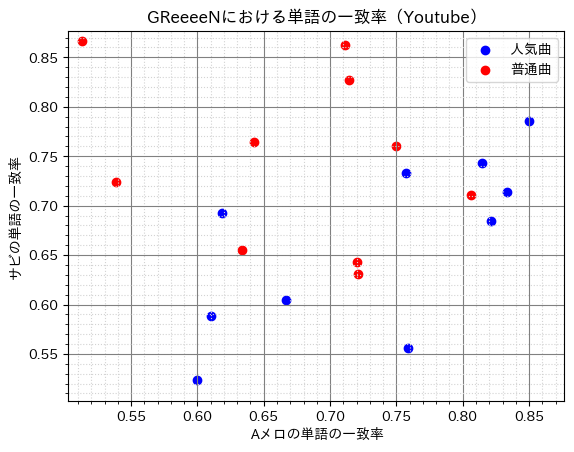

In [5]:
scatter(rates, xy_min_wmr, xy_max_wmr, ["youtube_url"], "youtube_play_times", "GReeeeNにおける単語の一致率（Youtube）", "Aメロの単語の一致率", "サビの単語の一致率")

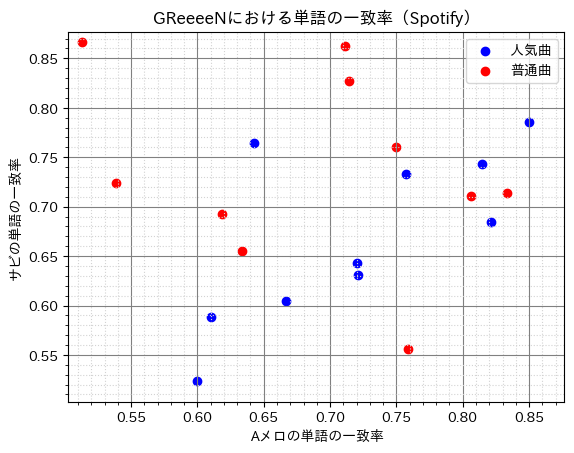

In [6]:
scatter(rates, xy_min_wmr, xy_max_wmr, ["spotify_id"], "spotify_popularity", "GReeeeNにおける単語の一致率（Spotify）", "Aメロの単語の一致率", "サビの単語の一致率")

# 木構造の類似度（全部分木）

In [7]:
rates, xy_min_ts, xy_max_ts = preprocess(df, "csv/GReeeeN_ts_20231119.csv")

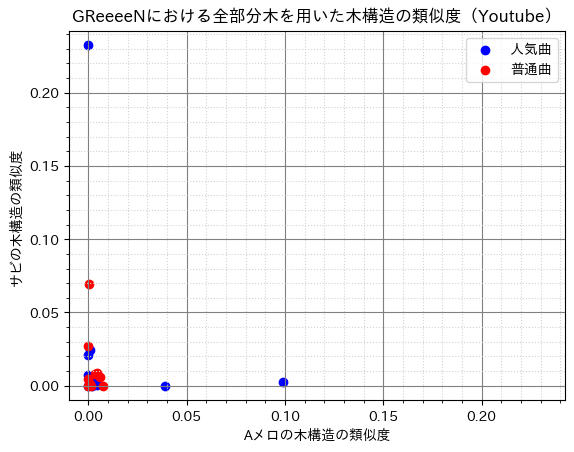

In [8]:
scatter(rates, xy_min_ts, xy_max_ts, ["youtube_url"], "youtube_play_times", "GReeeeNにおける全部分木を用いた木構造の類似度（Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

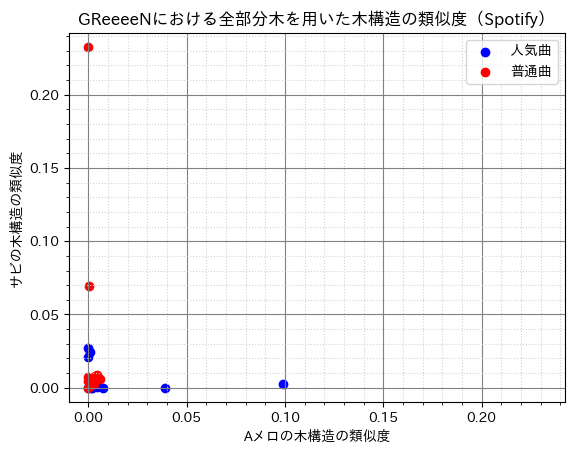

In [9]:
scatter(rates, xy_min_ts, xy_max_ts, ["spotify_id"], "spotify_popularity", "GReeeeNにおける全部分木を用いた木構造の類似度（Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子）

In [10]:
rates, xy_min_tspc, xy_max_tspc = preprocess(df, "csv/GReeeeN_tspc_20231119.csv")

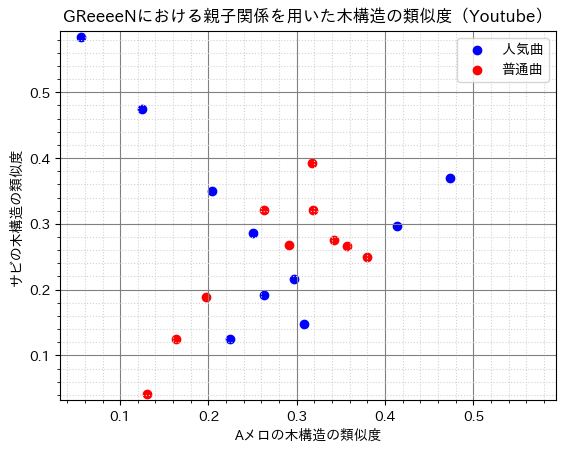

In [11]:
scatter(rates, xy_min_tspc, xy_max_tspc, ["youtube_url"], "youtube_play_times", "GReeeeNにおける親子関係を用いた木構造の類似度（Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

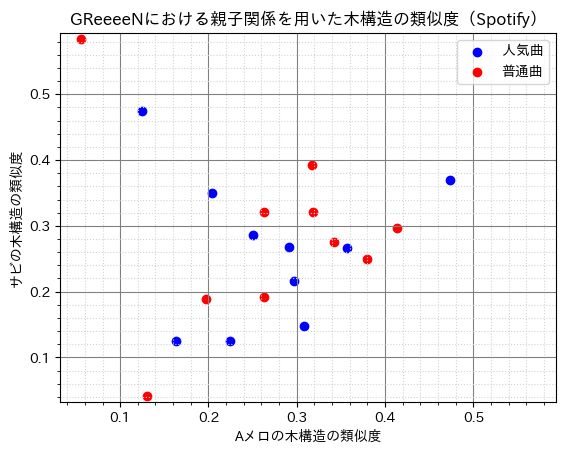

In [12]:
scatter(rates, xy_min_tspc, xy_max_tspc, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子, w1）
$${
    w1 = \frac{
        height_a * height_b
    }{
        height_a + height_b
    }
}$$

In [13]:
rates, xy_min_tspc_w1, xy_max_tspc_w1 = preprocess(df, "csv/GReeeeN_tspc_w1_20231119.csv")

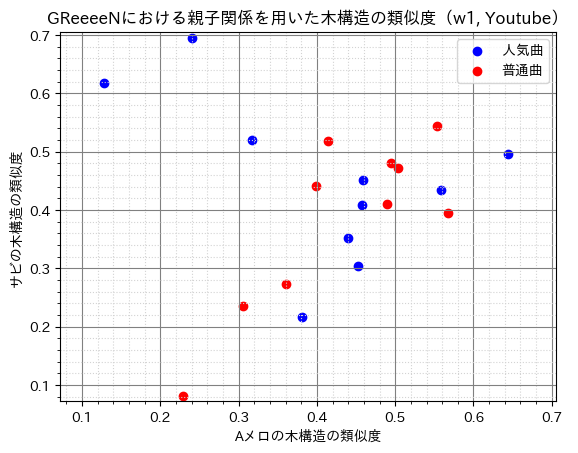

In [14]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["youtube_url"], "youtube_play_times", "GReeeeNにおける親子関係を用いた木構造の類似度（w1, Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

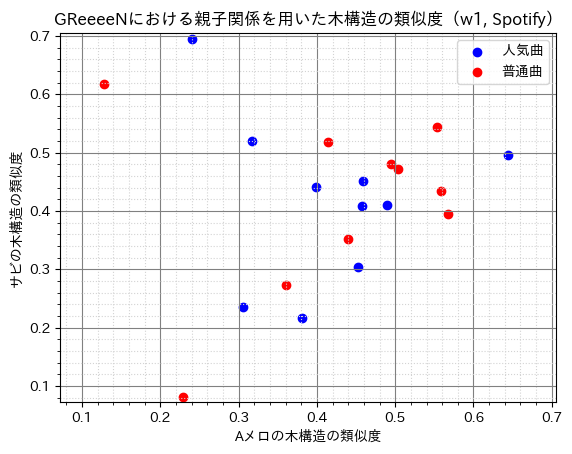

In [15]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（w1, Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子, w2）
$${
    w2 = \frac{
        1
    }{
        height_a + height_b
    }
}$$

In [16]:
rates, xy_min_tspc_w1, xy_max_tspc_w1 = preprocess(df, "csv/GReeeeN_tspc_w2_20231119.csv")

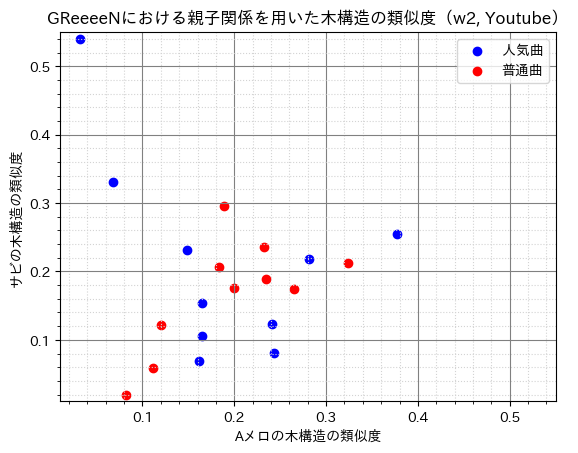

In [17]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["youtube_url"], "youtube_play_times", "GReeeeNにおける親子関係を用いた木構造の類似度（w2, Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

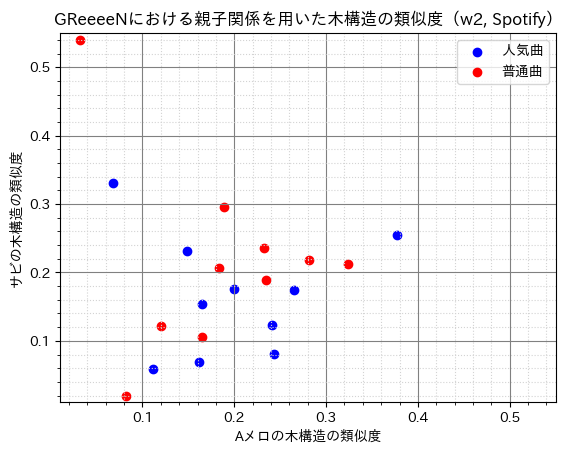

In [18]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（w2, Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子, w3）
$${
    w1 = \frac{
        1
    }{
        height_a * height_b
    }
}$$

In [19]:
rates, xy_min_tspc_w1, xy_max_tspc_w1 = preprocess(df, "csv/GReeeeN_tspc_w3_20231119.csv")

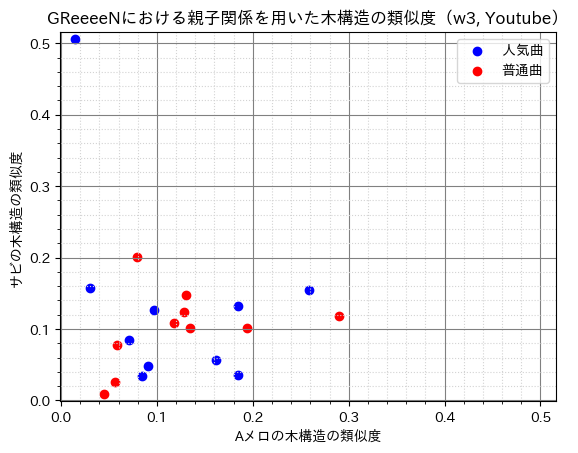

In [20]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["youtube_url"], "youtube_play_times", "GReeeeNにおける親子関係を用いた木構造の類似度（w3, Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

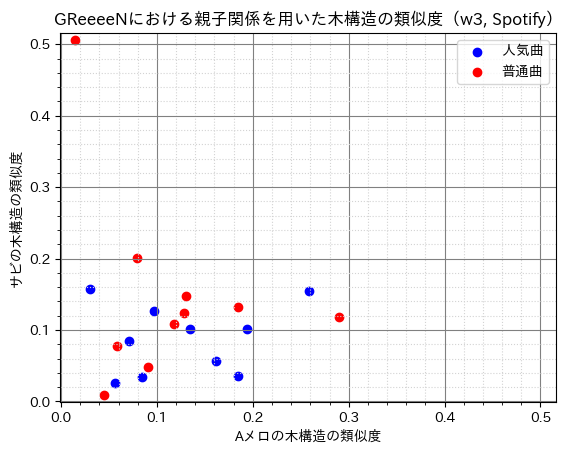

In [21]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（w3, Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子, w4）
$${
    w1 = height_a * height_b
}$$

In [22]:
rates, xy_min_tspc_w1, xy_max_tspc_w1 = preprocess(df, "csv/GReeeeN_tspc_w4_20231119.csv")

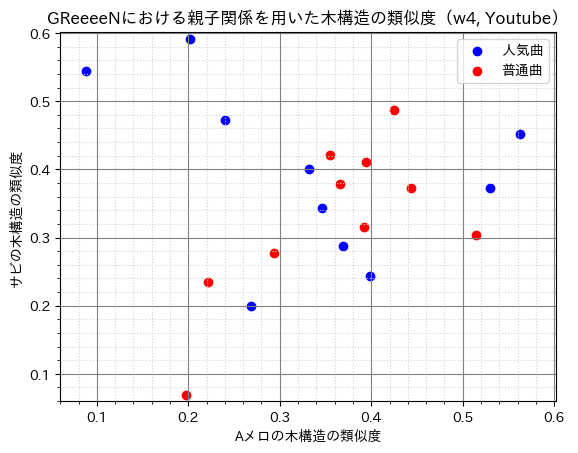

In [23]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["youtube_url"], "youtube_play_times", "GReeeeNにおける親子関係を用いた木構造の類似度（w4, Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

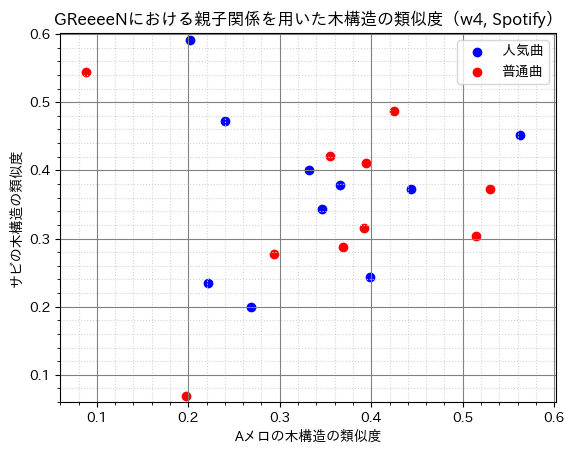

In [24]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（w4, Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子, w5）
$${
    w5 = height_a + height_b
}$$

In [25]:
rates, xy_min_tspc_w1, xy_max_tspc_w1 = preprocess(df, "csv/GReeeeN_tspc_w5_20231119.csv")

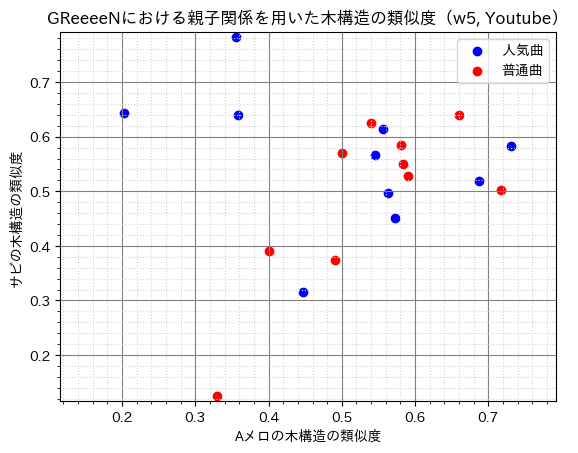

In [26]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["youtube_url"], "youtube_play_times", "GReeeeNにおける親子関係を用いた木構造の類似度（w5, Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

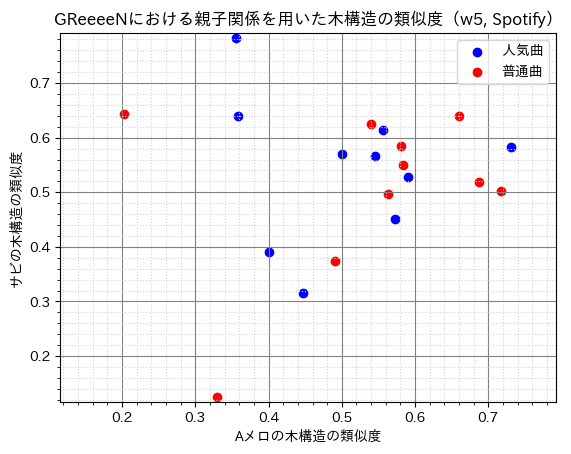

In [27]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（w5, Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子, w6）
$${
    w6 = \frac{
        height_a + height_b
    }{
        height_a * height_b
    }
}$$

In [28]:
rates, xy_min_tspc_w1, xy_max_tspc_w1 = preprocess(df, "csv/GReeeeN_tspc_w6_20231119.csv")

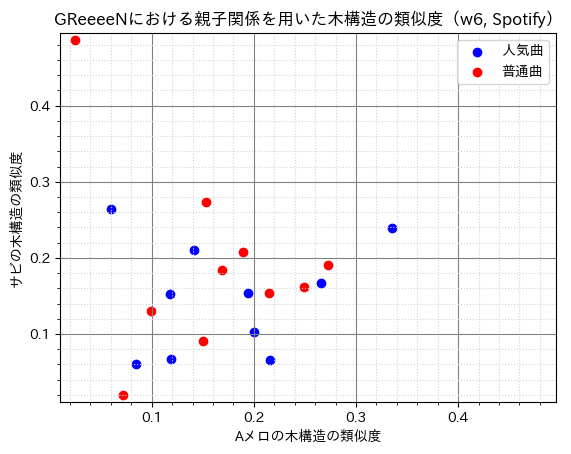

In [29]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（w6, Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

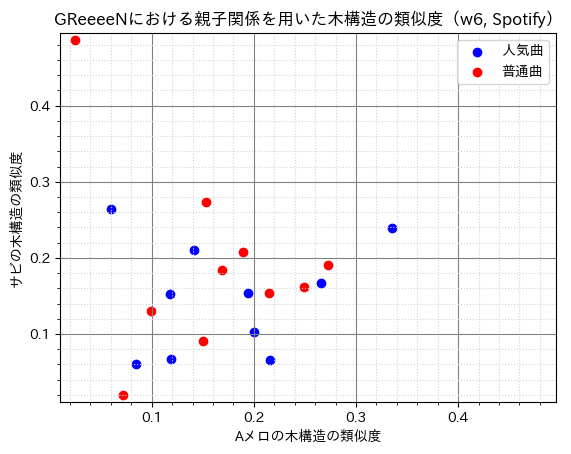

In [30]:
scatter(rates, xy_min_tspc_w1, xy_max_tspc_w1, ["spotify_id"], "spotify_popularity", "GReeeeNにおける親子関係を用いた木構造の類似度（w6, Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")